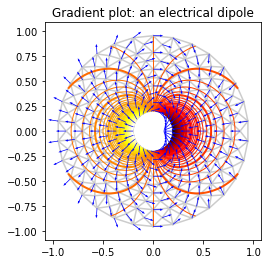

In [1]:
from matplotlib.tri import (
    Triangulation, UniformTriRefiner, CubicTriInterpolator)
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np


#-----------------------------------------------------------------------------
# Electrical potential of a dipole
#-----------------------------------------------------------------------------
def dipole_potential(x, y):
    """The electric dipole potential V, at position *x*, *y*."""
    r_sq = x**2 + y**2
    theta = np.arctan2(y, x)
    z = np.cos(theta)/r_sq
    return (np.max(z) - z) / (np.max(z) - np.min(z))


#-----------------------------------------------------------------------------
# Creating a Triangulation
#-----------------------------------------------------------------------------
# First create the x and y coordinates of the points.
n_angles = 30
n_radii = 10
min_radius = 0.2
radii = np.linspace(min_radius, 0.95, n_radii)

angles = np.linspace(0, 2 * np.pi, n_angles, endpoint=False)
angles = np.repeat(angles[..., np.newaxis], n_radii, axis=1)
angles[:, 1::2] += np.pi / n_angles

x = (radii*np.cos(angles)).flatten()
y = (radii*np.sin(angles)).flatten()
V = dipole_potential(x, y)

# Create the Triangulation; no triangles specified so Delaunay triangulation
# created.
triang = Triangulation(x, y)

# Mask off unwanted triangles.
triang.set_mask(np.hypot(x[triang.triangles].mean(axis=1),
                         y[triang.triangles].mean(axis=1))
                < min_radius)

#-----------------------------------------------------------------------------
# Refine data - interpolates the electrical potential V
#-----------------------------------------------------------------------------
refiner = UniformTriRefiner(triang)
tri_refi, z_test_refi = refiner.refine_field(V, subdiv=3)

#-----------------------------------------------------------------------------
# Computes the electrical field (Ex, Ey) as gradient of electrical potential
#-----------------------------------------------------------------------------
tci = CubicTriInterpolator(triang, -V)
# Gradient requested here at the mesh nodes but could be anywhere else:
(Ex, Ey) = tci.gradient(triang.x, triang.y)
E_norm = np.sqrt(Ex**2 + Ey**2)

#-----------------------------------------------------------------------------
# Plot the triangulation, the potential iso-contours and the vector field
#-----------------------------------------------------------------------------
fig, ax = plt.subplots()
ax.set_aspect('equal')
# Enforce the margins, and enlarge them to give room for the vectors.
ax.use_sticky_edges = False
ax.margins(0.07)

ax.triplot(triang, color='0.8')

levels = np.arange(0., 1., 0.01)
cmap = cm.get_cmap(name='hot', lut=None)
ax.tricontour(tri_refi, z_test_refi, levels=levels, cmap=cmap,
              linewidths=[2.0, 1.0, 1.0, 1.0])
# Plots direction of the electrical vector field
ax.quiver(triang.x, triang.y, Ex/E_norm, Ey/E_norm,
          units='xy', scale=10., zorder=3, color='blue',
          width=0.007, headwidth=3., headlength=4.)

ax.set_title('Gradient plot: an electrical dipole')
plt.show()